In [34]:
import random 
random.seed(0)
import os
import glob
import pickle
import xgboost, textblob, string
import numpy as np
import pandas as pd
from pandas import read_excel
import itertools 
import matplotlib
matplotlib.use('TkAgg')   
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

from sklearn.utils import shuffle
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.models import Sequential

In [35]:
#Data loading
#Negative cases from disease history notes
CHUSJ_neg = read_excel('data/neg/DiseaseHistory.xlsx')
CHUSJ_neg.columns = ['Notes', 'Label']

#Positive cases from disease history notes
CHUSJ_pos_med = read_excel('data/pos/HDmedication.xlsx')
CHUSJ_pos_med.columns = ['Notes', 'Label']
CHUSJ_pos_cv = read_excel('data/pos/HDproblemeCV.xlsx')
CHUSJ_pos_cv.columns = ['Notes', 'Label']
CHUSJ_pos_bnp = read_excel('data/pos/HDproBNP.xlsx')
CHUSJ_pos_bnp.columns = ['Notes', 'Label']

print("Disease history notes for negative cases:")
print(CHUSJ_neg.head())
print ("")
print("Disease history notes for positive cases:")
print ("HD Medication:")
print(CHUSJ_pos_med.head())
print ("")
print ("HD problem CV:")
print(CHUSJ_pos_cv.head())
print ("")
print ("HD proBNP:")
print(CHUSJ_pos_bnp.head())
print ("")
frames = [CHUSJ_neg, CHUSJ_pos_med, CHUSJ_pos_cv, CHUSJ_pos_bnp]
data = pd.concat(frames)

#Randomly shuffle the data
data = shuffle(data)
print('Data after shuffling')
print(data.head(10))

Disease history notes for negative cases:
                                               Notes  Label
0  Statut post-op de trachéostomie et reprise cur...      0
1  Pte admise x 11/06 pour dlr thoracique/dyspnée...      0
2  pte présente RGO + dlr thoracique/sensation de...      0
3  Césarienne d'urgence pour détresse fétale le 1...      0
4  Intubation avec TET 7.5 - facile, grade I  Ind...      0

Disease history notes for positive cases:
HD Medication:
                                               Notes  Label
0  PO immédiat de Lefort (chx mandibule) avec att...      1
1  Sur le plan anesthesique :  induction sufenta/...      1
2  SOP ce jour, Dr Vobecky, dr ruest anesthesie s...      1
3  Rupture amoureuse récente, mais désir de mouri...      1
4  Patiente a été en KT 20/10 pour installation s...      1

HD problem CV:
                                               Notes  Label
0  Actuellement hospitalisé en cardiologie. - Se ...      1
1  dernière visite vendredi 15/04 en cardiol

In [36]:
sentences_train, sentences_test, y_train, y_test = train_test_split(data.Notes, data.Label, test_size=0.4, random_state=0)

#### 2. Feature Engineering

We will implement the following different ideas in order to obtain relevant features from our dataset.

2.1 Word Embeddings as features

    2.3.1 Word Embeddings
    
    2.3.2 Keras Embedding Layer
    
    2.3.3 Using Pretrained Word Embeddings

2.2 Text / NLP based features

2.3 Topic Models as features

#### 2.1 Word Embeddings

Following snnipet shows how to use pre-trained word embeddings in the model. There are four essential steps:

* Loading the pretrained word embeddings
* Creating a tokenizer object
* Transforming text documents to sequence of tokens and pad them
* Create a mapping of token and their respective embeddings

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# sequence preprocessing 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

Xtrain_sq = tokenizer.texts_to_sequences(sentences_train)
Xtest_sq = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# pad_sequences
maxlen = 100
Xtrain_sq = pad_sequences(Xtrain_sq, padding='post', maxlen=maxlen)
Xtest_sq = pad_sequences(Xtest_sq, padding='post', maxlen=maxlen)


#### Keras Embedding Layer

In [40]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model_eb = Sequential()
model_eb.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_eb.add(layers.GlobalMaxPool1D())
model_eb.add(layers.Dense(10, activation='relu'))
model_eb.add(layers.Dense(1, activation='sigmoid'))
model_eb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_eb.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1114850   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,115,371
Trainable params: 1,115,371
Non-trainable params: 0
_________________________________________________________________


In [42]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0090 - accuracy: 0.9916 - val_loss: 0.8290 - val_accuracy: 0.8927
Epoch 2/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0086 - accuracy: 0.9928 - val_loss: 0.8906 - val_accuracy: 0.8903
Epoch 3/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0086 - accuracy: 0.9919 - val_loss: 0.8747 - val_accuracy: 0.8922
Epoch 4/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0087 - accuracy: 0.9934 - val_loss: 0.8573 - val_accuracy: 0.8936
Epoch 5/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0086 - accuracy: 0.9919 - val_loss: 0.8906 - val_accuracy: 0.8922
Epoch 6/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0091 - accuracy: 0.9913 - val_loss: 0.8868 - val_accuracy: 0.8927
Epoch 7/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.008

Epoch 57/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0078 - accuracy: 0.9938 - val_loss: 1.1184 - val_accuracy: 0.8927
Epoch 58/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0077 - accuracy: 0.9928 - val_loss: 1.1463 - val_accuracy: 0.8927
Epoch 59/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0079 - accuracy: 0.9938 - val_loss: 1.1171 - val_accuracy: 0.8993
Epoch 60/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0078 - accuracy: 0.9919 - val_loss: 1.1155 - val_accuracy: 0.8964
Epoch 61/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0077 - accuracy: 0.9934 - val_loss: 1.1500 - val_accuracy: 0.8941
Epoch 62/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0077 - accuracy: 0.9928 - val_loss: 1.1460 - val_accuracy: 0.8969
Epoch 63/100
3201/3201 [==============================] - 7s 2ms/step - loss: 0.0077 - accuracy: 0.9925 - val_loss: 1.1531 -

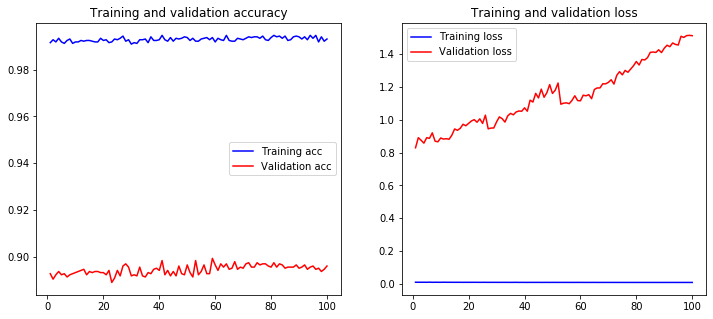

In [45]:
history_eb = model_eb.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_eb.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_eb.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_eb)

#### Using Pretrained Word Embeddings

#### 3. Model Building

We will implement following different classifiers for this purpose:

3.1 Convolutional Neural Network (CNN)
    
3.2 Long Short Term Model (LSTM)
    
3.3 Gated Recurrent Unit (GRU)
    
3.4 Bidirectional RNN (BiRNN)
    
3.5 Recurrent Convolutional Neural Network (RCNN)

#### 3.1 Convolutional Neural Network (CNN)

In [72]:
embedding_dim = 100

model_cnn = Sequential()
model_cnn.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_cnn.add(layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(10, activation='relu'))
model_cnn.add(layers.Dense(1, activation='sigmoid'))
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 2,295,129
Trainable params: 2,295,129
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 18s 6ms/step - loss: 0.3571 - accuracy: 0.8622 - val_loss: 0.2734 - val_accuracy: 0.8964
Epoch 2/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.1773 - accuracy: 0.9331 - val_loss: 0.2551 - val_accuracy: 0.9044
Epoch 3/100
3201/3201 [==============================] - 18s 5ms/step - loss: 0.0830 - accuracy: 0.9747 - val_loss: 0.2970 - val_accuracy: 0.8950
Epoch 4/100
3201/3201 [==============================] - 18s 6ms/step - loss: 0.0460 - accuracy: 0.9894 - val_loss: 0.3495 - val_accuracy: 0.9007
Epoch 5/100
3201/3201 [==============================] - 19s 6ms/step - loss: 0.0307 - accuracy: 0.9925 - val_loss: 0.3525 - val_accuracy: 0.8880
Epoch 6/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0345 - accuracy: 0.9928 - val_loss: 0.3610 - val_accuracy: 0.9007
Epoch 7/100
3201/3201 [==============================] - 17s 5ms/step - loss

3201/3201 [==============================] - 17s 5ms/step - loss: 0.0074 - accuracy: 0.9947 - val_loss: 1.0129 - val_accuracy: 0.8875
Epoch 57/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0111 - accuracy: 0.9938 - val_loss: 1.2822 - val_accuracy: 0.8857
Epoch 58/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.9691 - val_accuracy: 0.8857
Epoch 59/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0076 - accuracy: 0.9938 - val_loss: 0.9990 - val_accuracy: 0.8847
Epoch 60/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0074 - accuracy: 0.9941 - val_loss: 1.0076 - val_accuracy: 0.8857
Epoch 61/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0074 - accuracy: 0.9941 - val_loss: 1.0157 - val_accuracy: 0.8861
Epoch 62/100
3201/3201 [==============================] - 17s 5ms/step - loss: 0.0074 - accuracy: 0.9947 - val_loss: 1.0228 - val_a

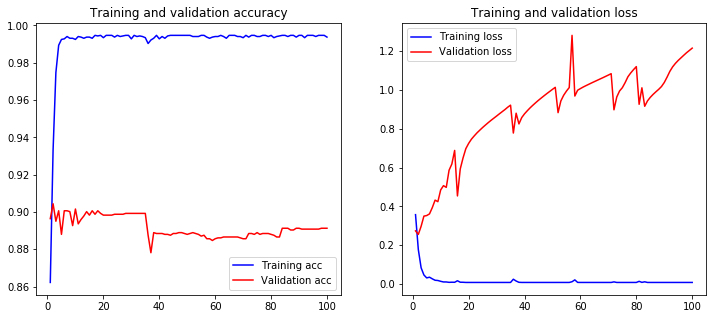

In [73]:
history_cnn = model_cnn.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_cnn.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_cnn.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_cnn)

#### 3.2 Long Short Term Model (LSTM)

In [74]:
embedding_dim = 100

model_lstm = Sequential()
model_lstm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_lstm.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(layers.Dense(10, activation='relu'))
model_lstm.add(layers.Dense(1, activation='sigmoid'))
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_31 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 11        
Total params: 2,311,121
Trainable params: 2,311,121
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.4785 - accuracy: 0.8282 - val_loss: 0.4533 - val_accuracy: 0.8318
Epoch 2/100
3201/3201 [==============================] - 27s 8ms/step - loss: 0.4423 - accuracy: 0.8344 - val_loss: 0.4511 - val_accuracy: 0.8322
Epoch 3/100
3201/3201 [==============================] - 27s 8ms/step - loss: 0.3552 - accuracy: 0.8657 - val_loss: 0.3674 - val_accuracy: 0.8538
Epoch 4/100
3201/3201 [==============================] - 27s 8ms/step - loss: 0.2882 - accuracy: 0.8947 - val_loss: 0.3817 - val_accuracy: 0.8374
Epoch 5/100
3201/3201 [==============================] - 27s 8ms/step - loss: 0.2924 - accuracy: 0.9016 - val_loss: 0.4081 - val_accuracy: 0.8411
Epoch 6/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.2466 - accuracy: 0.9078 - val_loss: 0.4401 - val_accuracy: 0.8374
Epoch 7/100
3201/3201 [==============================] - 27s 8ms/step - loss

3201/3201 [==============================] - 27s 9ms/step - loss: 0.0090 - accuracy: 0.9919 - val_loss: 0.9446 - val_accuracy: 0.8716
Epoch 57/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0082 - accuracy: 0.9934 - val_loss: 0.9798 - val_accuracy: 0.8749
Epoch 58/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0082 - accuracy: 0.9934 - val_loss: 0.9556 - val_accuracy: 0.8739
Epoch 59/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0113 - accuracy: 0.9931 - val_loss: 0.8865 - val_accuracy: 0.8636
Epoch 60/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0114 - accuracy: 0.9922 - val_loss: 0.8082 - val_accuracy: 0.8641
Epoch 61/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0089 - accuracy: 0.9941 - val_loss: 0.9021 - val_accuracy: 0.8702
Epoch 62/100
3201/3201 [==============================] - 27s 9ms/step - loss: 0.0085 - accuracy: 0.9944 - val_loss: 0.9269 - val_a

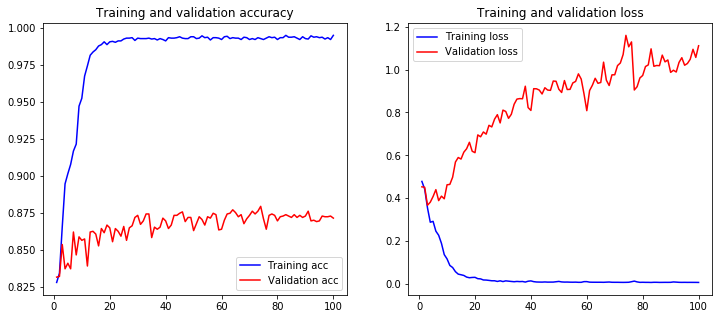

In [75]:
history_lstm = model_lstm.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_lstm.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lstm.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_lstm)

#### 3.3 Gated Recurrent Unit (GRU)

In [76]:
embedding_dim = 100

model_gru = Sequential()
model_gru.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_gru.add(layers.GRU(100, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(layers.Dense(10, activation='relu'))
model_gru.add(layers.Dense(1, activation='sigmoid'))
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_gru.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
gru_11 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dense_33 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 11        
Total params: 2,291,021
Trainable params: 2,291,021
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 31s 10ms/step - loss: 0.4375 - accuracy: 0.8366 - val_loss: 0.4198 - val_accuracy: 0.8472
Epoch 2/100
3201/3201 [==============================] - 30s 9ms/step - loss: 6803.2521 - accuracy: 0.8779 - val_loss: 0.4063 - val_accuracy: 0.8425
Epoch 3/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.3006 - accuracy: 0.8950 - val_loss: 0.4041 - val_accuracy: 0.8379
Epoch 4/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.2640 - accuracy: 0.9053 - val_loss: 0.4120 - val_accuracy: 0.8379
Epoch 5/100
3201/3201 [==============================] - 31s 10ms/step - loss: 0.2405 - accuracy: 0.9147 - val_loss: 0.4231 - val_accuracy: 0.8379
Epoch 6/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.2255 - accuracy: 0.9203 - val_loss: 0.4422 - val_accuracy: 0.8318
Epoch 7/100
3201/3201 [==============================] - 30s 9ms/step -

3201/3201 [==============================] - 30s 9ms/step - loss: 1.1427 - accuracy: 0.9300 - val_loss: 0.6200 - val_accuracy: 0.8276
Epoch 57/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1887 - accuracy: 0.9310 - val_loss: 0.6233 - val_accuracy: 0.8266
Epoch 58/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1876 - accuracy: 0.9319 - val_loss: 0.6287 - val_accuracy: 0.8271
Epoch 59/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1876 - accuracy: 0.9310 - val_loss: 0.6328 - val_accuracy: 0.8266
Epoch 60/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1865 - accuracy: 0.9313 - val_loss: 0.6300 - val_accuracy: 0.8290
Epoch 61/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1856 - accuracy: 0.9319 - val_loss: 0.6371 - val_accuracy: 0.8276
Epoch 62/100
3201/3201 [==============================] - 30s 9ms/step - loss: 0.1838 - accuracy: 0.9347 - val_loss: 0.6408 - val_a

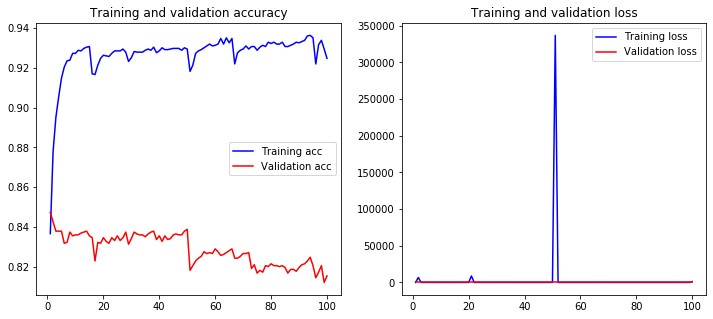

In [77]:
history_gru = model_gru.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_gru.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_gru.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_gru)

#### 3.4 Bidirectional RNN (BiRNN)

In [78]:
embedding_dim = 100

model_BiRnn = Sequential()
model_BiRnn.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_BiRnn.add(layers.Bidirectional(layers.GRU(100, dropout=0.2, recurrent_dropout=0.2)))
model_BiRnn.add(layers.Dense(10, activation='relu'))
model_BiRnn.add(layers.Dense(1, activation='sigmoid'))
model_BiRnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_BiRnn.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               120600    
_________________________________________________________________
dense_35 (Dense)             (None, 10)                2010      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 2,352,321
Trainable params: 2,352,321
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 44s 14ms/step - loss: 5001.3526 - accuracy: 0.8554 - val_loss: 0.3795 - val_accuracy: 0.8547
Epoch 2/100
3201/3201 [==============================] - 43s 13ms/step - loss: 1.5231 - accuracy: 0.9163 - val_loss: 0.3618 - val_accuracy: 0.8510
Epoch 3/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.2357 - accuracy: 0.9453 - val_loss: 0.3654 - val_accuracy: 0.8444
Epoch 4/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.1203 - accuracy: 0.9581 - val_loss: 0.3757 - val_accuracy: 0.8440
Epoch 5/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.2108 - accuracy: 0.9709 - val_loss: 0.3862 - val_accuracy: 0.8458
Epoch 6/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.0854 - accuracy: 0.9731 - val_loss: 0.4045 - val_accuracy: 0.8454
Epoch 7/100
3201/3201 [==============================] - 42s 13ms/s

3201/3201 [==============================] - 43s 13ms/step - loss: 0.2938 - accuracy: 0.9925 - val_loss: 0.8217 - val_accuracy: 0.8158
Epoch 57/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.0112 - accuracy: 0.9931 - val_loss: 0.8337 - val_accuracy: 0.8168
Epoch 58/100
3201/3201 [==============================] - 43s 13ms/step - loss: 0.0104 - accuracy: 0.9944 - val_loss: 0.8470 - val_accuracy: 0.8168
Epoch 59/100
3201/3201 [==============================] - 43s 13ms/step - loss: 0.0363 - accuracy: 0.9934 - val_loss: 0.8534 - val_accuracy: 0.8168
Epoch 60/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.0119 - accuracy: 0.9934 - val_loss: 0.8564 - val_accuracy: 0.8177
Epoch 61/100
3201/3201 [==============================] - 43s 13ms/step - loss: 0.0087 - accuracy: 0.9947 - val_loss: 0.8653 - val_accuracy: 0.8187
Epoch 62/100
3201/3201 [==============================] - 42s 13ms/step - loss: 0.0101 - accuracy: 0.9944 - val_loss: 0.8719 

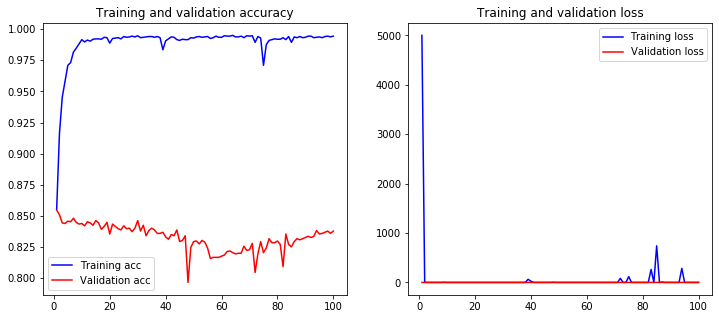

In [79]:
history_BiRnn = model_BiRnn.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_BiRnn.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_BiRnn.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_BiRnn)

#### 3.5 Recurrent Convolutional Neural Network (RCNN)

In [80]:
embedding_dim = 100

model_bcnn = Sequential()
model_bcnn.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_bcnn.add(layers.Conv1D(128, 5, activation='relu'))
model_bcnn.add(layers.Bidirectional(layers.GRU(100, dropout=0.2, recurrent_dropout=0.2)))
model_bcnn.add(layers.Dense(10, activation='relu'))
model_bcnn.add(layers.Dense(1, activation='sigmoid'))
model_bcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_bcnn.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200)               137400    
_________________________________________________________________
dense_37 (Dense)             (None, 10)                2010      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 11        
Total params: 2,433,249
Trainable params: 2,433,249
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 46s 14ms/step - loss: 69.1281 - accuracy: 0.8419 - val_loss: 0.4719 - val_accuracy: 0.8538
Epoch 2/100
3201/3201 [==============================] - 45s 14ms/step - loss: 87.9195 - accuracy: 0.8757 - val_loss: 0.3711 - val_accuracy: 0.8669
Epoch 3/100
3201/3201 [==============================] - 45s 14ms/step - loss: 0.2263 - accuracy: 0.9175 - val_loss: 0.3474 - val_accuracy: 0.8646
Epoch 4/100
3201/3201 [==============================] - 45s 14ms/step - loss: 1.6222 - accuracy: 0.9350 - val_loss: 0.3584 - val_accuracy: 0.8683
Epoch 5/100
3201/3201 [==============================] - 45s 14ms/step - loss: 3.5753 - accuracy: 0.9431 - val_loss: 0.3648 - val_accuracy: 0.8622
Epoch 6/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.1406 - accuracy: 0.9535 - val_loss: 0.3692 - val_accuracy: 0.8622
Epoch 7/100
3201/3201 [==============================] - 45s 14ms/st

3201/3201 [==============================] - 46s 14ms/step - loss: 0.0226 - accuracy: 0.9909 - val_loss: 0.6515 - val_accuracy: 0.8416
Epoch 57/100
3201/3201 [==============================] - 45s 14ms/step - loss: 0.0221 - accuracy: 0.9913 - val_loss: 0.6563 - val_accuracy: 0.8388
Epoch 58/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.0201 - accuracy: 0.9913 - val_loss: 0.6665 - val_accuracy: 0.8393
Epoch 59/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.2602 - accuracy: 0.9903 - val_loss: 0.6721 - val_accuracy: 0.8440
Epoch 60/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.0179 - accuracy: 0.9922 - val_loss: 0.6748 - val_accuracy: 0.8407
Epoch 61/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.0225 - accuracy: 0.9903 - val_loss: 0.6785 - val_accuracy: 0.8411
Epoch 62/100
3201/3201 [==============================] - 46s 14ms/step - loss: 0.0181 - accuracy: 0.9913 - val_loss: 0.6846 

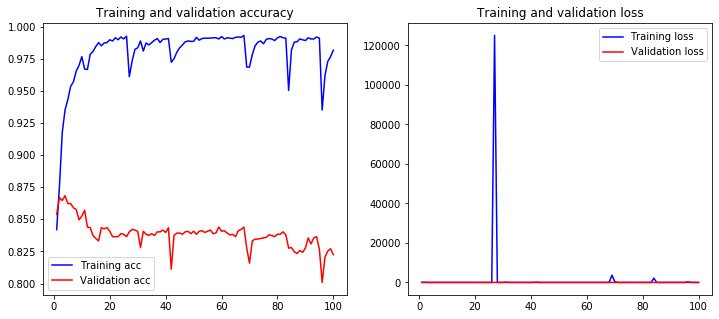

In [81]:
history_bcnn = model_bcnn.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_bcnn.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_bcnn.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_bcnn)

#### 3.6 LSTM and Convolutional Neural Network 

In [82]:
embedding_dim = 100

model_lcnn = Sequential()
model_lcnn.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model_lcnn.add(layers.Conv1D(128, 5, activation='relu'))
model_lcnn.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lcnn.add(layers.Dense(10, activation='relu'))
model_lcnn.add(layers.Dense(1, activation='sigmoid'))
model_lcnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_lcnn.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 100)          2229700   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               91600     
_________________________________________________________________
dense_39 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 11        
Total params: 2,386,449
Trainable params: 2,386,449
Non-trainable params: 0
_________________________________________________________________


Train on 3201 samples, validate on 2134 samples
Epoch 1/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.3966 - accuracy: 0.8516 - val_loss: 0.3917 - val_accuracy: 0.8730
Epoch 2/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.2841 - accuracy: 0.8910 - val_loss: 0.3131 - val_accuracy: 0.8613
Epoch 3/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.2297 - accuracy: 0.9125 - val_loss: 0.3381 - val_accuracy: 0.8702
Epoch 4/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.1798 - accuracy: 0.9325 - val_loss: 0.3594 - val_accuracy: 0.8857
Epoch 5/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.1481 - accuracy: 0.9466 - val_loss: 0.3676 - val_accuracy: 0.8857
Epoch 6/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.1297 - accuracy: 0.9616 - val_loss: 0.3839 - val_accuracy: 0.8810
Epoch 7/100
3201/3201 [==============================] - 33s 10ms/step

3201/3201 [==============================] - 33s 10ms/step - loss: 0.0074 - accuracy: 0.9941 - val_loss: 1.0020 - val_accuracy: 0.8875
Epoch 57/100
3201/3201 [==============================] - 34s 10ms/step - loss: 0.0074 - accuracy: 0.9938 - val_loss: 1.0249 - val_accuracy: 0.8875
Epoch 58/100
3201/3201 [==============================] - 34s 11ms/step - loss: 0.0074 - accuracy: 0.9941 - val_loss: 1.0414 - val_accuracy: 0.8875
Epoch 59/100
3201/3201 [==============================] - 33s 10ms/step - loss: 0.0074 - accuracy: 0.9934 - val_loss: 1.0290 - val_accuracy: 0.8871
Epoch 60/100
3201/3201 [==============================] - 34s 11ms/step - loss: 0.0074 - accuracy: 0.9947 - val_loss: 1.0465 - val_accuracy: 0.8866
Epoch 61/100
3201/3201 [==============================] - 34s 10ms/step - loss: 0.0074 - accuracy: 0.9941 - val_loss: 1.0637 - val_accuracy: 0.8866
Epoch 62/100
3201/3201 [==============================] - 34s 11ms/step - loss: 0.0120 - accuracy: 0.9947 - val_loss: 0.7187 

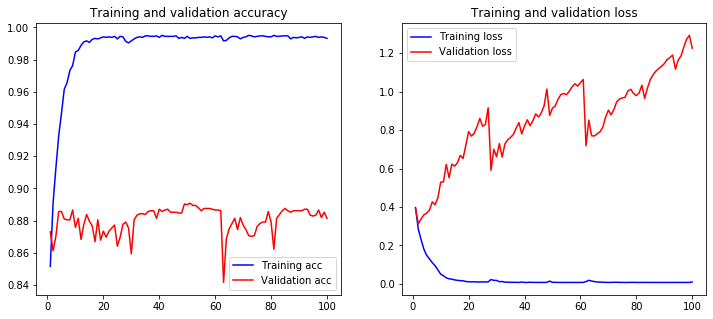

In [83]:
history_lcnn = model_lcnn.fit(Xtrain_sq, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(Xtest_sq, y_test),
                    batch_size=10)
loss, accuracy = model_lcnn.evaluate(Xtrain_sq, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_lcnn.evaluate(Xtest_sq, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_lcnn)